<a href="https://colab.research.google.com/github/mkvkanpur/field_theory/blob/main/HD_d_dim_field_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FT.py

In [2]:
%%writefile FT.py

import numpy as np
import math as m
from scipy.integrate import quad, romberg
from scipy.special import roots_jacobi

b = 1.5
tollerance = 1e-2
maxiter = 150

def area_sphere(d):
	return(2*np.pi**(d/2)/m.gamma(d/2.0))

def dvol_RG(d, v, z):
    G = 2*area_sphere(d-1)/((d-1)*area_sphere(d))
    return G * v**(d-1)* pow(1-z**2,(d-3)/2)

def dvol_flux(d, v):
    A = (area_sphere(d-1)/area_sphere(d))*4/(d-1)**2
    return A*v**(d-1)

####
#### Renormalized viscosity
####

def compute_nu1(d):

    def RG_CH1(d,v,z):
        w = np.sqrt(1 + v**2 - 2*v*z)
        denr = v**(2/3) + w**(2/3)
        F1 = (1-z**2)*(v-2*z)*(2*v*z-1)*v*w**(-8/3-d)
        F2 = (1-z**2)*(1-v**2)*(2*v*z-1)*v**(-2/3-d)/w**2
        return -dvol_RG(d,v,z)*(F1+F2)/denr

    def fv_RG_CH1(d,v):
        lower_lim_z = (v**2+1-b**2)/(2*v)
        upper_lim_z = v/2
        return quad(lambda z: RG_CH1(d,v,z), lower_lim_z, upper_lim_z)[0]

    integ_CH1 = romberg(lambda v: fv_RG_CH1(d,v), 1, b)
    return  np.sqrt(integ_CH1/(1-b**(-4/3)))

def compute_nu2(d, nu2_init):
    def RG_CH2(d,nu1,nu2,v,z):
        w = np.sqrt(1 + v**2 - 2*v*z)
        F3_1 = ((1-z**2)*v**(-2/3-d))/(nu1*v**(2/3) + nu2*w**(2/3))
        F3_2 = ((1-z**2)*v**2*w**(-8/3-d))/(nu2*v**(2/3) + nu1*w**(2/3))
        return dvol_RG(d,v,z) * (F3_1+F3_2)

    def fv_RG_CH2(d,nu1,nu2,v):
        lower_lim = (v**2+1-b**2)/(2*v)
        upper_lim = v/2
        return quad(lambda z: RG_CH2(d,nu1,nu2,v,z),lower_lim,upper_lim)[0]

    iter = 0
    nu1 = compute_nu1(d)
    nu2 = nu2_init
    while (1):
        iter += 1
        integ_CH2 = romberg(lambda v: fv_RG_CH2(d,nu1,nu2,v), 1, b)
        nu2_new = integ_CH2/(1-b**(-4/3))
        # print(integ_CH2, nu2_new)
        if ((abs(nu2_new -nu2)<tollerance) or (iter>maxiter)):
            break
        nu2 = nu2_new

    if (iter > maxiter):
        print("ERROR: compute_nu2() did not converge!")
    else:
        return nu2

########
# S(k,p,q)
########

def Su1u1(d,nu1,v,z):
    w = np.sqrt(1 + v**2 - 2*v*z)
    denr = nu1*(1 + v**(2/3)+w**(2/3))
    numr1 = 2*(2*v*z-1)*z*v * w**(-2)*(v*w)**(-2/3-d)
    numr2 = 2*(v-2*z)*z*v**2 * w**(-8/3-d)
    numr3 = 2*(1-v**2)*z*w**(-2) * v**(1/3-d)
    return (numr1+numr2+numr3)/denr

def Su2u2(d,nu1,nu2,v,z):
    w = np.sqrt(1 + v**2 - 2*v*z)
    denr = nu2*(1 + v**(2/3)) + nu1*w**(2/3)
    numr = v**2*w**(-8/3-d)*(v**(-2/3-d)-1)
    return numr/denr

########
# Kolmogorov's constant
########
def compute_Ko(d, v_lower_lim, nu1_eq_nu2):

    n=100
    alpha =  beta = (d-1)/2
    [rt, wt] = roots_jacobi(n, alpha, beta, mu=False)

    def flux_CH1(d,nu1,v):
        int_z = sum(Su1u1(d,nu1,v,rt)*wt)
        return int_z * dvol_flux(d,v)* np.log(1/v)

    def flux_CH2(d,nu1,nu2,v):
        int_z = sum(Su2u2(d,nu1,nu2,v,rt)*wt)
        return int_z * dvol_flux(d,v) * np.log(1/v)

    if (d==2):
        nu1 = compute_nu1(d)
        integ_flux_CH1 = romberg(lambda v: flux_CH1(d,nu1,v), v_lower_lim, 1)
        return (abs(integ_flux_CH1))**(-2/3)
    else:   # d > 2
        nu2 = compute_nu2(d, 0.40)
        if (nu1_eq_nu2):
            nu1 = nu2
        else:
            nu1 = compute_nu1(d)

        integ_flux_CH1 = romberg(lambda v: flux_CH1(d,nu1,v), v_lower_lim, 1)
        integ_flux_CH2 = romberg(lambda v: flux_CH2(d,nu1,nu2,v), 1e-7, 1)
        return (integ_flux_CH1+(d-2)*integ_flux_CH2)**(-2/3)


########
# Energy transfers T_{v}^1
########

def EnergyTr(d, v_array, ET_array, v_lower_lim):

    n=100
    alpha =  beta = (d-1)/2
    [rt, wt] = roots_jacobi(n, alpha, beta, mu=False)

    def flux_CH1(d,nu1,v):
        int_z = sum(Su1u1(d,nu1,v,rt)*wt)
        return int_z * dvol_flux(d,v)* np.log(1/v)

    def flux_CH2(d,nu1,nu2,v):
        int_z = sum(Su2u2(d,nu1,nu2,v,rt)*wt)
        return int_z * dvol_flux(d,v) * np.log(1/v)

    index = 0
    if (d == 2):
        nu1 = compute_nu1(d)
        nu1_eq_nu2 = False
        Ko = compute_Ko(2, 1e-7, nu1_eq_nu2)
        for v in v_array:
            integ1 = Ko**(3/2)*romberg(lambda v: flux_CH1(d,nu1,v), v, 1)
            ET_array[index] = integ1
            index += 1

    else:
        nu1 = nu2 = compute_nu2(d, 0.40)
        nu1_eq_nu2 = True
        Ko = compute_Ko(d, 0.22, nu1_eq_nu2) # 0.22 yields Ko = 1.64 for 3D

        for v in v_array:
            if (v>v_lower_lim):
                integ1 = romberg(lambda v: flux_CH1(d,nu1,v), v , 1)
            else:
                integ1 = romberg(lambda v: flux_CH1(d,nu1,v), 0.22 , 1)
            integ2 = romberg(lambda v: flux_CH2(d,nu1,nu2,v), v, 1)
            ET_array[index] = (integ1+(d-2)*integ2)*Ko**(3/2)
            index += 1

    return


########
# S2S
########
def compute_S2S(d, num_shells, s, Tmn):
    n=100
    alpha =  beta =  (d-1)/2
    [rt, wt] = roots_jacobi(n, alpha, beta, mu=False)

    def S2S_CH1(d,nu1,u,v):
        int_z = sum(Su1u1(d,nu1,v,rt)*wt)
        return int_z*dvol_flux(d,v)/u

    def S2S_CH2(d,nu1,nu2,u,v):
        int_z = sum(Su2u2(d,nu1,nu2,v,rt)*wt)
        return int_z*dvol_flux(d,v)/u


    if (d == 2):
        nu1 = compute_nu1(d)
        nu1_eq_nu2 = False
        Ko = compute_Ko(2, 1e-7, nu1_eq_nu2)
        for n_m in range(1,num_shells):
            Tmn[n_m] = romberg(lambda u: romberg(lambda v: S2S_CH1(d,nu1,u,v), \
                                  u*s**(-n_m),u*s**(-n_m+1)), 1/s, 1)

    else:
        nu1 = nu2 = compute_nu2(d, 0.40)
        nu1_eq_nu2 = True
        Ko = compute_Ko(d, 0.22, nu1_eq_nu2) # 0.22 yields Ko = 1.64 for 3D
        for n_m in range(1,num_shells):
            integ1 = romberg(lambda u: romberg(lambda v: S2S_CH1(d,nu1,u,v), \
                                  u*s**(-n_m),u*s**(-n_m+1)), 1/s, 1)
            integ2 = romberg(lambda u: romberg(lambda v: S2S_CH2(d,nu1,nu2,u,v), \
                                  u*s**(-n_m),u*s**(-n_m+1)), 1/s, 1)

            Tmn[n_m] =  integ1+(d-2)*integ2

    Tmn *= Ko**(3/2)
    return Tmn

########
# main()
########
'''
v_array = np.arange(1e-6,0.9,0.1)
ET_array = np.zeros(np.size(v_array))
for d in np.arange(2,6,1):
    EnergyTr(d, v_array, ET_array,1e-6)
    print(d, ET_array)

v_lower_lim = 0.22
s = 2**(1/4)
num_shells = 10
Tmn = np.zeros(num_shells)

for d in np.arange(2,3.1,1):
    compute_S2S(d, num_shells, s, Tmn)
    print(d, Tmn)
'''

'''
def main():
    Ko= compute_Ko(2, 0.22)

    v_array = np.arange(0.01,0.9,0.01)
    ET_array = np.zeros(np.size(v_array))
    EnergyTr(2, v_array, ET_array, 0.22)
    Ko = compute_Ko(2, 0.40)
    print("nu1,2,Ko = ", compute_nu1(3), compute_nu2(3,0.40), Ko)
    print(ET_array)


# Call the main function if the script is run directly
if __name__ == "__main__":
    main()
'''

Overwriting FT.py


In [ ]:
0.04649958*1.8**1.5


0.11229431954960485

In [ ]:
!python FT.py

/content/FT.py:119: RuntimeWarning: invalid value encountered in double_scalars
  return (integ_flux_CH1+(d-2)*integ_flux_CH2)**(-2/3)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from google.colab import files

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXGeneral'

mpl.rc('font', size=12)
mpl.rc('axes', titlesize=10) #fontsize of the title
mpl.rc('axes', labelsize=10) #fontsize of the x and y labels
mpl.rc('xtick', labelsize=10) #fontsize of the x tick labels
mpl.rc('ytick', labelsize=10) #fontsize of the y tick labels
mpl.rc('legend', fontsize=10) #fontsize of the legend

# Compute nu and Ko for various d's

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

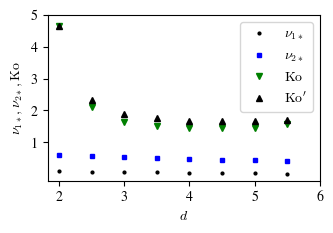

In [ ]:
import FT
import numpy as np

v_lower_lim = 0.22

d_array = np.arange(2,6,0.5)
nu1 = np.zeros(np.size(d_array))
nu2 = np.zeros(np.size(d_array))
Ko = np.zeros(np.size(d_array))
Kop = np.zeros(np.size(d_array))


nu1_eq_nu2 = False
for i in range(np.size(d_array)):
    nu1[i] = FT.compute_nu1(d_array[i])
    nu2[i] = FT.compute_nu2(d_array[i], 0.4)
    Ko[i] = FT.compute_Ko(d_array[i], v_lower_lim, nu1_eq_nu2)
    Kop[i] = FT.compute_Ko(d_array[i], v_lower_lim, True)

fig, ax = plt.subplots(figsize = (3.5,2.5))
ax.plot(d_array,nu1,'k.',markersize = 4, label=r'$\nu_{1*}$')
ax.plot(d_array,nu2,'bs', markersize = 3, label=r'$\nu_{2*}$')
ax.plot(d_array,Ko,'gv',markersize = 4, label=r'$\mathrm{Ko}$')
ax.plot(d_array,Kop,'k^', markersize = 4,label=r"$\mathrm{Ko'}$")


#ax.set_xlim([0,1])
#ax.set_ylim([0,1.2])
ax.set_xlabel('$d$')
ax.set_ylabel(r'$\nu_{1*}, \nu_{2*}, \mathrm{Ko}$')
ax.set_xticks([2,3,4,5,6])
ax.set_xticklabels([2,3,4,5,6])
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels([1,2,3,4,5])
plt.tight_layout(pad=1.1)
ax.legend(loc = 'upper right')
plt.savefig("nu_Ko.pdf")
files.download("nu_Ko.pdf")
plt.show()



In [ ]:
import FT
d = 3
v_lower_lim = 0.22
for FT.b in [1.1, 1.3, 1.5, 1.7, 1.9, 2.1]:
    print(FT.b, FT.compute_nu1(d), FT.compute_nu2(d, 0.4), \
          FT.compute_Ko(d, v_lower_lim,False))

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.535405e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.992366e-04
  warnings.warn(


1.1 0.008966901613619186 0.2416378356741737 1.6123982862763218
1.3 0.03944664231371621 0.4052756146975786 1.4156682837054508


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.457631e-04
  warnings.warn(


1.5 0.07010155927481088 0.5377887959188123 1.6423470192215555


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.228449e-04
  warnings.warn(


1.7 0.09218179072634201 0.6291294047590937 1.8048808907161433


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.079464e-04
  warnings.warn(


1.9 0.09942400970647054 0.7214338690759159 1.9872411432124057
2.1 0.08460777485692741 0.783084390894451 2.159168327361171


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.021168e-04
  warnings.warn(


In [ ]:
nu1_eq_nu2 = False
i = 0
for d in [2,2.1,2.15,2.2,3,4,5]:
    nu1[i] = FT.compute_nu1(d)
    nu2[i] = FT.compute_nu2(d, 0.4)
    Ko[i] = FT.compute_Ko(d, v_lower_lim, nu1_eq_nu2)
    Kop[i] = FT.compute_Ko(d, v_lower_lim, True)
    i+=1


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.295856e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.908144e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.109999e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.798452e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.941204e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.698863e-04
  warnings.warn(
/usr

In [ ]:
print(nu1,'\n',nu2,'\n',Ko, '\n',Kop)

[0.09834434 0.09495175 0.0933177  0.09172212 0.07010156 0.0491259
 0.0304972  0.0203072 ] 
 [0.61443901 0.60336838 0.59809559 0.59298469 0.5377888  0.47348199
 0.4356928  0.42107312] 
 [ 4.6608732  11.63383089  5.49958748  4.01253143  1.64234702  1.43829564
  1.46474197  1.56363461] 
 [4.6608732  5.79118541 4.39516795 3.68386036 1.88802996 1.68210477
 1.67614027 1.69255909]


# Plot ∫Tv

[-1.00020322 -0.7698127  -0.54208675 -0.33781465 -0.15850959 -0.00396792
  0.12632339  0.23287531  0.31613474  0.37650506  0.41440232  0.43033208
  0.42498451  0.39935234  0.35488481  0.29370562  0.21895963  0.13546552
  0.05135872  0.        ]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.242213e-05
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.244092e-05
  warnings.warn(


[1.0000742  0.91562076 0.83037271 0.75070982 0.67637529 0.63868736
 0.60693347 0.57315618 0.53691743 0.49785427 0.45568805 0.41024198
 0.36146852 0.30948939 0.25465462 0.19763371 0.13957085 0.08239512
 0.02965941 0.        ]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.680823e-05
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.274440e-05
  warnings.warn(


[1.00007087 0.91940793 0.83799909 0.76192866 0.69091787 0.64506562
 0.6043663  0.56342316 0.52172158 0.47881421 0.43432844 0.38798073
 0.33959991 0.28916263 0.2368469  0.18311643 0.12886534 0.07570822
 0.0267711  0.        ]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.052083e-05
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.309844e-06
  warnings.warn(


[1.00006895 0.9215975  0.84241409 0.76844503 0.69941622 0.65068671
 0.60674894 0.56329584 0.51978058 0.47570858 0.43064324 0.38421871
 0.33616229 0.28633047 0.23476448 0.18177981 0.12812051 0.07526717
 0.02627469 0.        ]


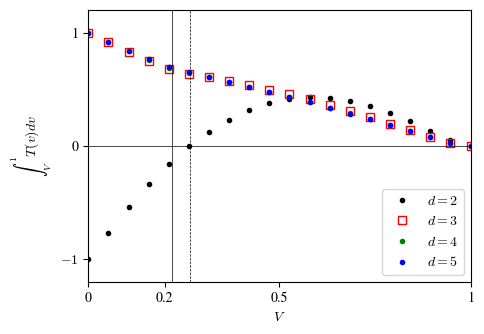

In [ ]:
import FT
import numpy as np

v_lower_lim = 0.22

v_array = np.linspace(1e-4,1.00,20)
ET_array = np.zeros(np.size(v_array))

ET = np.zeros([4,np.size(v_array)])
ind = 0
for d2 in np.arange(2,6,1):
    FT.EnergyTr(d2, v_array, ET_array,v_lower_lim)
    ET[ind,:] = ET_array
    print(ET[ind,:])
    ind += 1

fig, ax = plt.subplots(figsize = (5,3.5))
ax.plot(v_array,ET[0,:],'k.',label=r'$d=2$')
ax.plot(v_array,ET[1,:],'rs',markerfacecolor='none',label=r'$d=3$')
ax.plot(v_array,ET[2,:],'g.',label=r'$d=4$')
ax.plot(v_array,ET[3,:],'b.',label=r'$d=5$')
ax.axhline(0,color='k',lw=0.5)
ax.axvline(0.22,color='k',lw=0.5)
ax.axvline(0.265,color='k',linestyle='--',lw=0.5)

ax.set_xlim([0,1])
ax.set_ylim([-1.2,1.2])
ax.set_xlabel('$V$')
ax.set_ylabel('$\int_{V}^1 T(v)dv$')
ax.set_xticks([0,0.2,0.5,1])
ax.set_xticklabels([0,0.2,0.5,1])
ax.set_yticks([-1.,0,1.])
ax.set_yticklabels(['$-1$',0,1])
plt.tight_layout()
ax.legend(loc = 'lower right')
#plt.savefig("Tv.pdf")
#files.download("Tv.pdf")
plt.show()




/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.507185e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.227157e-04
  warnings.warn(


[-1.00020322 -0.7698127  -0.54208675 -0.33781465 -0.15850959 -0.00396792
  0.12632339  0.23287531  0.31613474  0.37650506  0.41440232  0.43033208
  0.42498451  0.39935234  0.35488481  0.29370562  0.21895963  0.13546552
  0.05135872  0.        ]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.908144e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.942931e-05
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 5.195227e-05
  warnings.warn(


[-0.48262351 -0.19628348  0.08499163  0.3340371   0.54804951  0.72658917
  0.86974014  0.97767708  1.05057096  1.08861717  1.09212281  1.06160141
  0.99809126  0.90305056  0.77894789  0.62950785  0.46039319  0.28045158
  0.10491648  0.        ]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.798452e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.927162e-05
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.896578e-05
  warnings.warn(


[0.02671515 0.1852273  0.34026621 0.47628361 0.5913692  0.68500858
 0.75703095 0.80735205 0.8359152  0.84270826 0.82781823 0.79151293
 0.73434764 0.65730364 0.56197569 0.45084532 0.32772637 0.19862381
 0.07395464 0.        ]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.698863e-04
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.908900e-05
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.625435e-05
  warnings.warn(


[0.25952953 0.35976566 0.45725643 0.54174976 0.61174116 0.66668022
 0.7062779  0.73032999 0.73867441 0.73120292 0.70790103 0.66890935
 0.61460505 0.54570902 0.463432   0.36968978 0.26745514 0.16144037
 0.05987319 0.        ]


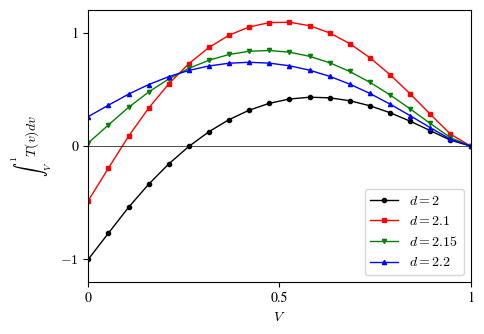

In [ ]:
import FT
import numpy as np

v_lower_lim = 1e-5

v_array = np.linspace(1e-4,1.00,20)
ET_array = np.zeros(np.size(v_array))

ET = np.zeros([5,np.size(v_array)])
ind = 0
for d2 in [2,2.1,2.15,2.2]:
    FT.EnergyTr(d2, v_array, ET_array,v_lower_lim)
    ET[ind,:] = ET_array
    print(ET[ind,:])
    ind += 1

fig, ax = plt.subplots(figsize = (5,3.5))
ax.plot(v_array,ET[0,:],'k.-',lw=1,label=r'$d=2$')
ax.plot(v_array,ET[1,:],'rs-',lw=1,markersize=3,label=r'$d=2.1$')
ax.plot(v_array,ET[2,:],'gv-',lw=1,markersize=3,label=r'$d=2.15$')
ax.plot(v_array,ET[3,:],'b^-',lw=1,markersize=3,label=r'$d=2.2$')
#ax.plot(v_array,ET[4,:],'r.',label=r'$d=5$')
ax.axhline(0,color='k',lw=0.5)
#ax.axvline(0.22,color='k',lw=0.5)
#ax.axvline(0.265,color='k',linestyle='--',lw=0.5)

ax.set_xlim([0,1])
ax.set_ylim([-1.2,1.2])
ax.set_xlabel('$V$')
ax.set_ylabel('$\int_{V}^1 T(v)dv$')
ax.set_xticks([0,0.5,1])
ax.set_xticklabels([0,0.5,1])
ax.set_yticks([-1.,0,1.])
ax.set_yticklabels(['$-1$',0,1])
plt.tight_layout()
ax.legend(loc = 'lower right')
#plt.savefig("Tv_balance.pdf")
#files.download("Tv_balance.pdf")
plt.show()

# Plot S2S

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.507185e-04
  warnings.warn(


2 [ 0.          0.29285149  0.05930219  0.00334171 -0.01464702 -0.01957843
 -0.01955076 -0.01768658 -0.01527748 -0.01286585]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.242213e-05
  warnings.warn(


3 [0.         0.19965077 0.06836569 0.03281903 0.01791798 0.01065856
 0.00677548 0.00454381 0.00318141 0.00230486]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.680823e-05
  warnings.warn(


4 [0.         0.18513216 0.06509449 0.03258657 0.01881423 0.01192365
 0.00808193 0.00575335 0.0042433  0.00320937]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:1074: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.052083e-05
  warnings.warn(


5 [0.         0.18373317 0.06422768 0.03239236 0.01903242 0.01232504
 0.00853358 0.00618869 0.00463352 0.00354542]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

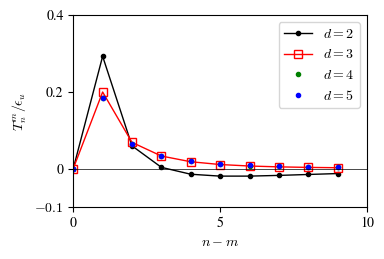

In [ ]:
#### Shell-to-shell
import FT
import numpy as np

v_lower_lim = 0.22
s = 2**(1/4)
num_shells = 10
Tmn = np.zeros(num_shells)
S2S_d = np.zeros([4,num_shells])
xarr = np.arange(0,10,1)
ind = 0
for d in np.arange(2,6,1):
    FT.compute_S2S(d, num_shells, s, Tmn)
    S2S_d[ind,:] = Tmn
    print(d, S2S_d[ind,:])
    ind += 1


fig, ax = plt.subplots(figsize = (4,2.75))
ax.plot(xarr, S2S_d[0,:],'k.-',lw=1,label=r'$d=2$')
ax.plot(xarr, S2S_d[1,:],'rs-', lw=1, markerfacecolor='none',label=r'$d=3$')
ax.plot(xarr, S2S_d[2,:],'g.',label=r'$d=4$')
ax.plot(xarr, S2S_d[3,:],'b.',label=r'$d=5$')
ax.axhline(0,color='k',lw=0.5)


ax.set_xlim([0,10])
ax.set_ylim([-0.1,0.3])
ax.set_xlabel('$n-m$')
ax.set_ylabel('$T^m_n/\epsilon_u$')
ax.set_xticks([0,5,10])
ax.set_xticklabels([0,5,10])
ax.set_yticks([-0.1,0,0.2,0.4])
ax.set_yticklabels(['$-0.1$',0,0.2,0.4])

plt.tight_layout()
ax.legend(loc = 'upper right')
plt.savefig("S2S.pdf")
files.download("S2S.pdf")
plt.show()


# Plot Su1u1, Su2u2

<ipython-input-31-78cef6302d11>:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2,1].set_xticklabels(['$-1$',0,1]); ax[2,1].set_yticklabels([])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 550x700 with 0 Axes>

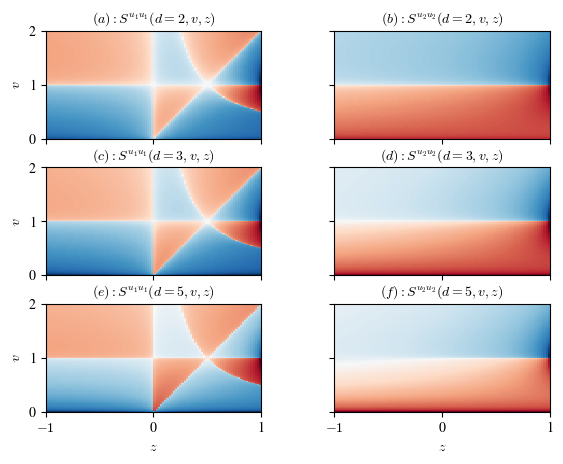

In [ ]:
import FT

Nx = 100; Ny=100
eps = 1e-2
X, Y = np.mgrid[-1+eps:1-eps:complex(0, Nx), eps:2-eps:complex(0, Ny)]
Skpq_CH1_array = np.zeros([Nx,Ny])
Skpq_CH2_array = np.zeros([Nx,Ny])

fig = plt.figure(figsize=(5.5,7.0))
fig, ax = plt.subplots(nrows=3, ncols=2)

########
d=2
nu1 = FT.compute_nu1(d); nu2 = FT.compute_nu2(d, 0.4)
Skpq_CH1_array = FT.Su1u1(d,nu1, Y,X)
Skpq_CH2_array = FT.Su2u2(d,nu1,nu2, Y,X)

vmin_my = np.min(Skpq_CH1_array)
vmax_my = np.max(Skpq_CH1_array)
pcm = ax[0,0].pcolormesh(X, Y, Skpq_CH1_array,
          norm=colors.SymLogNorm(linthresh=1e-4, linscale=1e-4,
          vmin=vmin_my, vmax=vmax_my), cmap='RdBu_r')
maxlog = int(np.ceil( np.log10(vmax_my) ))
minlog = int(np.ceil( np.log10(-vmin_my) ))

logthresh = 5 #generate logarithmic ticks
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-1)]
                    +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1)] )

vmin_my2 = np.min(Skpq_CH2_array)
vmax_my2 = np.max(Skpq_CH2_array)
pcm = ax[0,1].pcolormesh(X, Y, Skpq_CH2_array,
          norm=colors.SymLogNorm(linthresh=1e-4, linscale=1e-4,
          vmin=vmin_my, vmax=vmax_my), cmap='RdBu_r')
maxlog= int(np.ceil( np.log10(vmax_my) ))
minlog= int(np.ceil( np.log10(-vmin_my) ))

logthresh = 5
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-1)]
                    +[0.0]
                    +[(10**x) for x in range(-logthresh,maxlog+1)] )

########
d=3
nu1 = FT.compute_nu1(d); nu2 = FT.compute_nu2(d, 0.4)
Skpq_CH1_array = FT.Su1u1(d,nu1, Y,X)
Skpq_CH2_array = 0.1*FT.Su2u2(d,nu1,nu2, Y,X)

vmin_my = np.min(Skpq_CH1_array)
vmax_my = np.max(Skpq_CH1_array)
pcm = ax[1,0].pcolormesh(X, Y, Skpq_CH1_array,
          norm=colors.SymLogNorm(linthresh=1e-4, linscale=1e-4,
          vmin=vmin_my, vmax=vmax_my), cmap='RdBu_r')
maxlog= int(np.ceil( np.log10(vmax_my) ))
minlog= int(np.ceil( np.log10(-vmin_my) ))

logthresh = 5
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-1)]
                    +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1)] )

vmin_my = np.min(Skpq_CH2_array)
vmax_my = np.max(Skpq_CH2_array)
pcm = ax[1,1].pcolormesh(X, Y, Skpq_CH2_array,
          norm=colors.SymLogNorm(linthresh=1e-4, linscale=1e-4,
          vmin=vmin_my, vmax=vmax_my), cmap='RdBu_r')
maxlog= int(np.ceil( np.log10(vmax_my) ))
minlog= int(np.ceil( np.log10(-vmin_my) ))

logthresh = 5
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-1)]
                    +[0.0]
                    +[(10**x) for x in range(-logthresh,maxlog+1)] )

########
d=5
nu1 = FT.compute_nu1(d); nu2 = FT.compute_nu2(d, 0.4)
Skpq_CH1_array = FT.Su1u1(d,nu1, Y,X)
Skpq_CH2_array = 0.1*FT.Su2u2(d,nu1,nu2, Y,X)

vmin_my = np.min(Skpq_CH1_array)
vmax_my = np.max(Skpq_CH1_array)
pcm = ax[2,0].pcolormesh(X, Y, Skpq_CH1_array,
          norm=colors.SymLogNorm(linthresh=1e-4, linscale=1e-4,
          vmin=vmin_my, vmax=vmax_my), cmap='RdBu_r')
maxlog= int(np.ceil( np.log10(vmax_my) ))
minlog= int(np.ceil( np.log10(-vmin_my) ))

logthresh = 5
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-1)]
                    +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1)] )

vmin_my = np.min(Skpq_CH2_array)
vmax_my = np.max(Skpq_CH2_array)
pcm = ax[2,1].pcolormesh(X, Y, Skpq_CH2_array,
          norm=colors.SymLogNorm(linthresh=1e-4, linscale=1e-4,
          vmin=vmin_my, vmax=vmax_my), cmap='RdBu_r')
maxlog= int(np.ceil( np.log10(vmax_my) ))
minlog= int(np.ceil( np.log10(-vmin_my) ))

logthresh = 5
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-1)]
                    +[0.0]
                    +[(10**x) for x in range(-logthresh,maxlog+1)] )
asp_ratio = 0.5
ax[0,0].set_aspect(asp_ratio)
ax[0,1].set_aspect(asp_ratio)
ax[1,0].set_aspect(asp_ratio)
ax[1,1].set_aspect(asp_ratio)
ax[2,0].set_aspect(asp_ratio)
ax[2,1].set_aspect(asp_ratio)


ax[0,0].set_ylabel('$v$')
ax[0,0].set_yticks([0,1,2])
ax[0,0].set_yticklabels([0, 1,2]); ax[0,0].set_xticklabels([])
ax[1,0].set_ylabel('$v$')
ax[1,0].set_yticks([0,1,2]); ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([0, 1,2])
ax[2,0].set_ylabel('$v$'); ax[2,0].set_xlabel('$z$')
ax[2,0].set_yticks([0,1,2])
ax[0,0].set_xticks([-1,0,1]); ax[1,0].set_xticks([-1,0,1])
ax[2,0].set_xticks([-1,0,1])
ax[2,0].set_xticklabels(['$-1$',0,1])
ax[2,0].set_yticklabels([0, 1,2])


ax[0,1].set_xticklabels([]); ax[0,1].set_yticklabels([])
ax[1,1].set_xticklabels([]); ax[1,1].set_yticklabels([])
ax[2,1].set_xticklabels(['$-1$',0,1]); ax[2,1].set_yticklabels([])
ax[0,1].set_xticks([-1,0,1]); ax[0,1].set_yticks([0,1,2])
ax[1,1].set_xticks([-1,0,1]); ax[1,1].set_yticks([0,1,2])
ax[2,1].set_xticks([-1,0,1]); ax[2,1].set_yticks([0,1,2])
ax[2,1].set_xlabel('$z$')

ax[0,0].set_title('$(a): S^{u_1 u_1}(d=2,v,z)$')
ax[0,1].set_title('$(b): S^{u_2 u_2}(d=2,v,z)$')
ax[1,0].set_title('$(c): S^{u_1 u_1}(d=3,v,z)$')
ax[1,1].set_title('$(d): S^{u_2 u_2}(d=3,v,z)$')
ax[2,0].set_title('$(e): S^{u_1 u_1}(d=5,v,z)$')
ax[2,1].set_title('$(f): S^{u_2 u_2}(d=5,v,z)$')

#fig.colorbar(pcm, ticks=tick_locations)

plt.tight_layout(h_pad=0,w_pad=0)
#plt.savefig("Skpq.pdf")
#files.download("Skpq.pdf")

plt.show()